#Before starting:
* This notebook is meant to run on Google Colaboratory;
* It requires you to download a third party software, otherwise it will not run. (I know it's tedious but I don't own the program and so I can't share it with you);
* I suggest to use an environment with a GPU.


##Preliminaries

###Install 'tensorflow-model-optimization' for Quantization Aware Training (QAT)

###Get 'stm32tflm' software

* Download 'X-CUBE-AI-Linux' package from https://www.st.com/en/embedded-software/x-cube-ai.html;
* Extract the 'stm32tflm' executable from the downloaded package;
* Put it in the folder you're working (usually '/content/' for Google Colaboratory).

## How to use GPU in local Tensorflow fow windows

https://www.tensorflow.org/install/pip#windows-native_1

conda create --name tf python=3.9

conda deactivate
conda activate tf

conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0

pip install --upgrade pip

pip install "tensorflow<2.11" 

python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

Enable the execution of the 'stm32tflm' program

In [1]:
from tensorflow import keras
from pathlib import Path
import tensorflow as tf
import numpy as np
import subprocess
import datetime
import shutil
import glob
import re
import os

In [2]:
# Check for available GPU devices
gpu_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpu_devices))

if gpu_devices:
    print("Found GPU(s):", gpu_devices)
else:
    print("No GPU devices found. TensorFlow is likely using the CPU.")

Num GPUs Available:  1
Found GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
class OurNAS():
  architecture_name = 'resulting_architecture'
  def __init__(self, evaluate_model_fnc, input_shape, num_classes, learning_rate, evaluate_model):
    self.evaluate_model_fnc = evaluate_model_fnc
    self.model_count = 0
    self.model_name = ""
    self.input_shape = input_shape
    self.num_classes = num_classes
    self.learning_rate = learning_rate
    self.evaluate_model = evaluate_model

  def create_model(self, k, c):
    kernel_size = (3,3)
    pool_size = (2,2)
    pool_strides = (2,2)

    number_of_cells_limited = False
    number_of_mac = 0

    inputs = keras.Input(shape=self.input_shape)

    #convolutional base
    n = int(k)
    multiplier = 2

    #first convolutional layer
    c_in = self.input_shape[2]
    x = keras.layers.Conv2D(n, kernel_size, padding='same')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    number_of_mac = number_of_mac + (c_in * kernel_size[0] * kernel_size[1] * x.shape[1] * x.shape[2] * x.shape[3])

    #adding cells
    for i in range(1, c + 1) :
        if x.shape[1] <= 1 or x.shape[2] <= 1 :
            number_of_cells_limited = True
            break;
        n = int(np.ceil(n * multiplier))
        multiplier = multiplier - 2**-i
        x = keras.layers.MaxPooling2D(pool_size=pool_size, strides=pool_strides, padding='valid')(x)
        c_in = x.shape[3]
        x = keras.layers.Conv2D(n, kernel_size, padding='same')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)
        number_of_mac = number_of_mac + (c_in * kernel_size[0] * kernel_size[1] * x.shape[1] * x.shape[2] * x.shape[3])

    #classifier
    x = keras.layers.GlobalAveragePooling2D()(x)
    input_shape = x.shape[1]
    x = keras.layers.Dense(n)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    number_of_mac = number_of_mac + (input_shape * x.shape[1])
    x = keras.layers.Dense(self.num_classes)(x)
    x = keras.layers.BatchNormalization()(x)
    outputs = keras.layers.Softmax()(x)
    number_of_mac = number_of_mac + (x.shape[1] * outputs.shape[1])

    model = keras.Model(inputs=inputs, outputs=outputs)

    opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    model.compile(optimizer=opt,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

    model.summary()

    return model, number_of_mac, number_of_cells_limited

  def search(self):
    self.model_counter = 0
    epsilon = 0.005
    k0 = 4

    start = datetime.datetime.now()

    k = k0
    previous_architecture = self.explore_num_cells(k)
    k = 2 * k
    current_architecture = self.explore_num_cells(k)

    if (current_architecture['max_val_acc'] > previous_architecture['max_val_acc']) :
        previous_architecture = current_architecture
        k = 2 * k
        current_architecture = self.explore_num_cells(k)
        while(current_architecture['max_val_acc'] > previous_architecture['max_val_acc'] + epsilon) :
            previous_architecture = current_architecture
            k = 2 * k
            current_architecture = self.explore_num_cells(k)
    else :
        k = k0 / 2
        current_architecture = self.explore_num_cells(k)
        while(current_architecture['max_val_acc'] >= previous_architecture['max_val_acc']) :
            previous_architecture = current_architecture
            k = k / 2
            current_architecture = self.explore_num_cells(k)

    resulting_architecture = previous_architecture
    end = datetime.datetime.now()

    return resulting_architecture, end-start

  def explore_num_cells(self, k) :
      previous_architecture = {'k': -1, 'c': -1, 'max_val_acc': -2}
      current_architecture = {'k': -1, 'c': -1, 'max_val_acc': -1}
      c = -1
      k = int(k)

      while(current_architecture['max_val_acc'] > previous_architecture['max_val_acc']) :
          previous_architecture = current_architecture
          c = c + 1
          self.model_counter = self.model_counter + 1
          current_architecture = self.evaluate_model_process(k, c)
          print(f"\n\n\n{current_architecture}\n\n\n")
      return previous_architecture


  def evaluate_model_process(self, k, c):
    if k > 0 :
      self.model_name = f"k_{k}_c_{c}"
      model, MACC, number_of_cells_limited = self.create_model(k, c)
      result_property_dict = self.evaluate_model(model, MACC, number_of_cells_limited, self.model_name)
      result_property_dict["k"] = k
      result_property_dict["c"] = c if not number_of_cells_limited else "Not feasible"
      return result_property_dict
    else :
      return{'k': 'unfeasible', 'c': c, 'max_val_acc': -3}

##ColabNAS code

In [4]:
class ColabNAS :
    architecture_name = 'resulting_architecture'
    def __init__(self, max_RAM, max_Flash, max_MACC, path_to_training_set, val_split, cache=False, input_shape=(50,50,3), save_path='.', path_to_stm32tflm='stm32tflm.exe') :
        self.learning_rate = 1e-3
        self.batch_size = 128
        self.epochs = 100 #minimum 2

        self.max_MACC = max_MACC
        self.max_Flash = max_Flash
        self.max_RAM = max_RAM
        self.path_to_training_set = path_to_training_set
        self.num_classes = len(next(os.walk(path_to_training_set))[1])
        self.val_split = val_split
        self.cache = cache
        self.input_shape = input_shape
        self.save_path = Path(save_path)

        self.path_to_trained_models = self.save_path / "trained_models"
        self.path_to_trained_models.mkdir(parents=True, exist_ok=True)

        self.path_to_stm32tflm = Path(path_to_stm32tflm)

        self.load_training_set()

    def load_training_set(self):
        if 3 == self.input_shape[2] :
            color_mode = 'rgb'
        elif 1 == self.input_shape[2] :
            color_mode = 'grayscale'

        train_ds = tf.keras.utils.image_dataset_from_directory(
            directory= self.path_to_training_set,
            labels='inferred',
            label_mode='categorical',
            color_mode=color_mode,
            batch_size=self.batch_size,
            image_size=self.input_shape[0:2],
            shuffle=True,
            seed=11,
            validation_split=self.val_split,
            subset='training'
        )

        validation_ds = tf.keras.utils.image_dataset_from_directory(
            directory= self.path_to_training_set,
            labels='inferred',
            label_mode='categorical',
            color_mode=color_mode,
            batch_size=self.batch_size,
            image_size=self.input_shape[0:2],
            shuffle=True,
            seed=11,
            validation_split=self.val_split,
            subset='validation'
        )

        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.2, fill_mode='constant', interpolation='bilinear'),
            #tf.keras.layers.Rescaling(1./255)
            ])

        if self.cache :
            self.train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
            self.validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
        else :
            self.train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)
            self.validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    def get_data(self):
        return self.train_ds, self.validation_ds

    def quantize_model_uint8(self, model_name) :
        def representative_dataset():
            count = 0
            for images, labels in self.train_ds:
                for i in range(images.shape[0]):
                    if count >= 150:
                        return
                    # Expand dims to make it (1, H, W, C)
                    yield [tf.dtypes.cast(images[i:i+1], tf.float32)]
                    count += 1

        model = tf.keras.models.load_model(self.path_to_trained_models / f"{model_name}.h5")
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = representative_dataset
        converter.target_spec.supported_types = [tf.int8]
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8
        tflite_quant_model = converter.convert()

        with open(self.path_to_trained_models / f"{model_name}.tflite", 'wb') as f:
            f.write(tflite_quant_model)

        (self.path_to_trained_models / f"{model_name}.h5").unlink()

    def evaluate_flash_and_peak_RAM_occupancy(self, model_name) :
        #quantize model to evaluate its peak RAM occupancy and its Flash occupancy
        self.quantize_model_uint8(model_name)

        #evaluate its peak RAM occupancy and its Flash occupancy using STMicroelectronics' X-CUBE-AI
        proc = subprocess.Popen([self.path_to_stm32tflm, self.path_to_trained_models / f"{model_name}.tflite"], stdout=subprocess.PIPE)
        try:
            outs, errs = proc.communicate(timeout=15)
            Flash, RAM = re.findall(r'\d+', str(outs))
        except subprocess.TimeoutExpired:
            proc.kill()
            outs, errs = proc.communicate()
            print("stm32tflm error")
            exit()

        return int(Flash), int(RAM)

    def evaluate_model(self, model, MACC, number_of_cells_limited, model_name) :
        print(f"\n{model_name}\n")
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            str(self.path_to_trained_models / f"{model_name}.h5"), monitor='val_accuracy',
            verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        #One epoch of training must be done before quantization, which is needed to evaluate RAM and Flash occupancy
        model.fit(self.train_ds, epochs=1, validation_data=self.validation_ds, validation_freq=1)
        model.save(self.path_to_trained_models / f"{model_name}.h5")
        Flash, RAM = self.evaluate_flash_and_peak_RAM_occupancy(model_name)
        print(f"\nRAM: {RAM},\t Flash: {Flash},\t MACC: {MACC}\n")
        if MACC <= self.max_MACC and Flash <= self.max_Flash and RAM <= self.max_RAM and not number_of_cells_limited :
            hist = model.fit(self.train_ds, epochs=self.epochs - 1, validation_data=self.validation_ds, validation_freq=1, callbacks=[checkpoint])
            self.quantize_model_uint8(model_name)
        return {'RAM': RAM if RAM <= self.max_RAM else "Outside the upper bound",
                'Flash': Flash if Flash <= self.max_Flash else "Outside the upper bound",
                'MACC': MACC if MACC <= self.max_MACC else "Outside the upper bound",
                'max_val_acc':
                np.around(np.amax(hist.history['val_accuracy']), decimals=3)
                if 'hist' in locals() else -3}

    def search(self, NAS):
      nas = NAS(self.evaluate_model, self.input_shape, self.num_classes, self.learning_rate, self.evaluate_model)
      resulting_architecture, take_time = nas.search()

      if (resulting_architecture['max_val_acc'] > 0) :
            resulting_architecture_name = f"k_{resulting_architecture['k']}_c_{resulting_architecture['c']}.tflite"
            self.path_to_resulting_architecture = self.save_path / f"resulting_architecture_{resulting_architecture_name}"
            (self.path_to_trained_models / f"{resulting_architecture_name}").rename(self.path_to_resulting_architecture)
            shutil.rmtree(self.path_to_trained_models)
            print(f"\nResulting architecture: {resulting_architecture}\n")
      else :
          print(f"\nNo feasible architecture found\n")
      print(f"Elapsed time (search): {take_time}\n")

      return self.path_to_resulting_architecture

## SEP

In [5]:
# class OurNAS():
#   def __init__(self, evaluate_model_fnc):
#     self.architecture_name = 'resulting_architecture'
#     self.evaluate_model_fnc = evaluate_model_fnc
#     self.model = None
#     self.model_count = 0

#   def create_model(self, k, c):
#     # create model
#     # return model, MACC, is_valid # is_valid is status that check if the architecture is valid or not
#     pass

#   def search(self):
#     # count self.model_count every iter
#     # use PSO algorithm to fine optimize model architechture and check constraint is meet (like)
#     # self.model
#     pass

#   def evaluate_model_process(self):
#     # call the evaluate_model_func(self.model)
#     # model, MACC, number_of_cells_limited = self.Model(k, c)
#     pass

#   def objective_funtion(self):
#     return self.evaluate_model_fnc(self.model) # placeholder objective function (now, it only use model accuracy) in future i will add more objective

##Try ColabNAS!

###download a small dataset

In [6]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = Path(data_dir).with_suffix('')

###Run HW-NAS
target: STM32L412KBU3 (273 CoreMark, 40 kiB RAM, 128 kiB Flash)

In [7]:
import numpy as np
import tensorflow as tf

input_shape = (50,50,3)

#target: STM32L412KBU3
#273 CoreMark, 40 kiB RAM, 128 kiB Flash
peak_RAM_upper_bound = 40960
Flash_upper_bound = 131072
MACC_upper_bound = 2730000 #CoreMark * 1e4

#Each dataset must comply with the following structure
#main_directory/
#...class_a/
#......a_image_1.jpg
#......a_image_2.jpg
#...class_b/
#......b_image_1.jpg
#......b_image_2.jpg
path_to_training_set = data_dir
val_split = 0.3

#whether or not to cache datasets in memory
#if the dataset cannot fit in the main memory, the application will crash
cache = True

#where to save results
save_path = ''

#to show the GPU used
!nvidia-smi

colabNAS = ColabNAS(peak_RAM_upper_bound, Flash_upper_bound, MACC_upper_bound, path_to_training_set, val_split, cache, input_shape, save_path=save_path)

#search
path_to_tflite_model = colabNAS.search(OurNAS)

Tue Jan  6 00:11:11 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 591.59                 Driver Version: 591.59         CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
| 47%   53C    P8             34W /  350W |    1194MiB /  12288MiB |     31%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmpd7_y43n0\assets


INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmpd7_y43n0\assets
c:\Users\Jimmy\miniconda3\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "



RAM: 19968,	 Flash: 3904,	 MACC: 270041

Epoch 1/99
20/21 [===========================>..] - ETA: 0s - loss: 1.6461 - accuracy: 0.2418
Epoch 1: val_accuracy improved from -inf to 0.18256, saving model to trained_models\k_4_c_0.h5
21/21 [==============================] - 0s 17ms/step - loss: 1.6451 - accuracy: 0.2421 - val_loss: 1.5867 - val_accuracy: 0.1826
Epoch 2/99
15/21 [====================>.........] - ETA: 0s - loss: 1.6142 - accuracy: 0.2792
Epoch 2: val_accuracy improved from 0.18256 to 0.19074, saving model to trained_models\k_4_c_0.h5
21/21 [==============================] - 0s 10ms/step - loss: 1.5926 - accuracy: 0.2880 - val_loss: 1.5870 - val_accuracy: 0.1907
Epoch 3/99
15/21 [====================>.........] - ETA: 0s - loss: 1.5712 - accuracy: 0.3083
Epoch 3: val_accuracy improved from 0.19074 to 0.21435, saving model to trained_models\k_4_c_0.h5
21/21 [==============================] - 0s 10ms/step - loss: 1.5494 - accuracy: 0.3157 - val_loss: 1.5697 - val_accuracy: 0.

INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmps_s6nnqq\assets


INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmps_s6nnqq\assets





{'RAM': 19968, 'Flash': 3904, 'MACC': 270041, 'max_val_acc': 0.532, 'k': 4, 'c': 0}



Model: "model_1"


c:\Users\Jimmy\miniconda3\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 4)         112       
                                                                 
 batch_normalization_3 (Batc  (None, 50, 50, 4)        16        
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 50, 50, 4)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 4)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 8)         296       
          

INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmptqf_ll1a\assets


INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmptqf_ll1a\assets



RAM: 20480,	 Flash: 5592,	 MACC: 450089

Epoch 1/99
 1/21 [>.............................] - ETA: 0s - loss: 1.7491 - accuracy: 0.2109

c:\Users\Jimmy\miniconda3\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


19/21 [==========================>...] - ETA: 0s - loss: 1.7617 - accuracy: 0.2336
Epoch 1: val_accuracy improved from -inf to 0.17257, saving model to trained_models\k_4_c_1.h5
21/21 [==============================] - 0s 19ms/step - loss: 1.7609 - accuracy: 0.2328 - val_loss: 2.0588 - val_accuracy: 0.1726
Epoch 2/99
19/21 [==========================>...] - ETA: 0s - loss: 1.6303 - accuracy: 0.2726
Epoch 2: val_accuracy improved from 0.17257 to 0.21253, saving model to trained_models\k_4_c_1.h5
21/21 [==============================] - 0s 12ms/step - loss: 1.6276 - accuracy: 0.2721 - val_loss: 1.6603 - val_accuracy: 0.2125
Epoch 3/99
17/21 [=======================>......] - ETA: 0s - loss: 1.5008 - accuracy: 0.3254
Epoch 3: val_accuracy improved from 0.21253 to 0.27520, saving model to trained_models\k_4_c_1.h5
21/21 [==============================] - 0s 13ms/step - loss: 1.4875 - accuracy: 0.3367 - val_loss: 1.5671 - val_accuracy: 0.2752
Epoch 4/99
19/21 [==========================>...

INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmpagkknrmv\assets


INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmpagkknrmv\assets
c:\Users\Jimmy\miniconda3\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "





{'RAM': 20480, 'Flash': 5592, 'MACC': 450089, 'max_val_acc': 0.612, 'k': 4, 'c': 1}



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 4)         112       
                                                                 
 batch_normalization_7 (Batc  (None, 50, 50, 4)        16        
 hNormalization)                                                 
                                                                 
 re_lu_5 (ReLU)              (None, 50, 50, 4)         0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 4)        0         
 2D)                                                             
                                   

INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmp0uf9fjpf\assets


INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmp0uf9fjpf\assets
c:\Users\Jimmy\miniconda3\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "



RAM: 20992,	 Flash: 7848,	 MACC: 574585

Epoch 1/99
18/21 [========================>.....] - ETA: 0s - loss: 1.4623 - accuracy: 0.3242
Epoch 1: val_accuracy improved from -inf to 0.26975, saving model to trained_models\k_4_c_2.h5
21/21 [==============================] - 0s 22ms/step - loss: 1.4547 - accuracy: 0.3379 - val_loss: 1.5808 - val_accuracy: 0.2698
Epoch 2/99
18/21 [========================>.....] - ETA: 0s - loss: 1.3558 - accuracy: 0.4301
Epoch 2: val_accuracy improved from 0.26975 to 0.29973, saving model to trained_models\k_4_c_2.h5
21/21 [==============================] - 0s 13ms/step - loss: 1.3498 - accuracy: 0.4371 - val_loss: 1.5512 - val_accuracy: 0.2997
Epoch 3/99
19/21 [==========================>...] - ETA: 0s - loss: 1.2822 - accuracy: 0.4951
Epoch 3: val_accuracy improved from 0.29973 to 0.33061, saving model to trained_models\k_4_c_2.h5
21/21 [==============================] - 0s 12ms/step - loss: 1.2784 - accuracy: 0.4947 - val_loss: 1.5035 - val_accuracy: 0.

INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmph5a469kg\assets


INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmph5a469kg\assets
c:\Users\Jimmy\miniconda3\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "





{'RAM': 20992, 'Flash': 7848, 'MACC': 574585, 'max_val_acc': 0.618, 'k': 4, 'c': 2}



Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 4)         112       
                                                                 
 batch_normalization_12 (Bat  (None, 50, 50, 4)        16        
 chNormalization)                                                
                                                                 
 re_lu_9 (ReLU)              (None, 50, 50, 4)         0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 4)        0         
 2D)                                                             
                                   

INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmpjwpq7lvj\assets


INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmpjwpq7lvj\assets
c:\Users\Jimmy\miniconda3\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "



RAM: 21504,	 Flash: 10936,	 MACC: 632986

Epoch 1/99
20/21 [===========================>..] - ETA: 0s - loss: 1.2730 - accuracy: 0.4836
Epoch 1: val_accuracy improved from -inf to 0.22525, saving model to trained_models\k_4_c_3.h5
21/21 [==============================] - 0s 19ms/step - loss: 1.2717 - accuracy: 0.4846 - val_loss: 1.5895 - val_accuracy: 0.2252
Epoch 2/99
16/21 [=====================>........] - ETA: 0s - loss: 1.1798 - accuracy: 0.5464
Epoch 2: val_accuracy improved from 0.22525 to 0.24069, saving model to trained_models\k_4_c_3.h5
21/21 [==============================] - 0s 14ms/step - loss: 1.1750 - accuracy: 0.5457 - val_loss: 1.5609 - val_accuracy: 0.2407
Epoch 3/99
17/21 [=======================>......] - ETA: 0s - loss: 1.1401 - accuracy: 0.5643
Epoch 3: val_accuracy improved from 0.24069 to 0.33333, saving model to trained_models\k_4_c_3.h5
21/21 [==============================] - 0s 14ms/step - loss: 1.1331 - accuracy: 0.5648 - val_loss: 1.5298 - val_accuracy: 0

INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmp8ppkojue\assets


INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmp8ppkojue\assets
c:\Users\Jimmy\miniconda3\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "





{'RAM': 21504, 'Flash': 10936, 'MACC': 632986, 'max_val_acc': 0.589, 'k': 4, 'c': 3}



Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 8)         224       
                                                                 
 batch_normalization_18 (Bat  (None, 50, 50, 8)        32        
 chNormalization)                                                
                                                                 
 re_lu_14 (ReLU)             (None, 50, 50, 8)         0         
                                                                 
 global_average_pooling2d_4   (None, 8)                0         
 (GlobalAveragePooling2D)                                        
                                  

INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmpfp5iytc7\assets


INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmpfp5iytc7\assets



RAM: 30208,	 Flash: 4336,	 MACC: 540089

Epoch 1/99


c:\Users\Jimmy\miniconda3\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


16/21 [=====================>........] - ETA: 0s - loss: 1.7305 - accuracy: 0.2583
Epoch 1: val_accuracy improved from -inf to 0.18256, saving model to trained_models\k_8_c_0.h5
21/21 [==============================] - 0s 17ms/step - loss: 1.7109 - accuracy: 0.2643 - val_loss: 1.7579 - val_accuracy: 0.1826
Epoch 2/99
19/21 [==========================>...] - ETA: 0s - loss: 1.6258 - accuracy: 0.3076
Epoch 2: val_accuracy did not improve from 0.18256
21/21 [==============================] - 0s 10ms/step - loss: 1.6229 - accuracy: 0.3095 - val_loss: 1.6767 - val_accuracy: 0.1717
Epoch 3/99
20/21 [===========================>..] - ETA: 0s - loss: 1.5551 - accuracy: 0.3395
Epoch 3: val_accuracy improved from 0.18256 to 0.19982, saving model to trained_models\k_8_c_0.h5
21/21 [==============================] - 0s 11ms/step - loss: 1.5551 - accuracy: 0.3398 - val_loss: 1.6382 - val_accuracy: 0.1998
Epoch 4/99
19/21 [==========================>...] - ETA: 0s - loss: 1.4918 - accuracy: 0.3721
E

INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmpmdr1r3hq\assets


INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmpmdr1r3hq\assets
c:\Users\Jimmy\miniconda3\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "





{'RAM': 30208, 'Flash': 4336, 'MACC': 540089, 'max_val_acc': 0.593, 'k': 8, 'c': 0}



Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 50, 50, 8)         224       
                                                                 
 batch_normalization_21 (Bat  (None, 50, 50, 8)        32        
 chNormalization)                                                
                                                                 
 re_lu_16 (ReLU)             (None, 50, 50, 8)         0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 25, 25, 8)        0         
 2D)                                                             
                                   

INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmpbq7n4h_x\assets


INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmpbq7n4h_x\assets
c:\Users\Jimmy\miniconda3\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "



RAM: 30720,	 Flash: 7192,	 MACC: 1260281

Epoch 1/99
20/21 [===========================>..] - ETA: 0s - loss: 1.3853 - accuracy: 0.4398
Epoch 1: val_accuracy improved from -inf to 0.22797, saving model to trained_models\k_8_c_1.h5
21/21 [==============================] - 0s 22ms/step - loss: 1.3840 - accuracy: 0.4406 - val_loss: 1.6162 - val_accuracy: 0.2280
Epoch 2/99
19/21 [==========================>...] - ETA: 0s - loss: 1.2785 - accuracy: 0.4959
Epoch 2: val_accuracy improved from 0.22797 to 0.29609, saving model to trained_models\k_8_c_1.h5
21/21 [==============================] - 0s 12ms/step - loss: 1.2764 - accuracy: 0.4920 - val_loss: 1.6057 - val_accuracy: 0.2961
Epoch 3/99
19/21 [==========================>...] - ETA: 0s - loss: 1.2182 - accuracy: 0.5206
Epoch 3: val_accuracy improved from 0.29609 to 0.30064, saving model to trained_models\k_8_c_1.h5
21/21 [==============================] - 0s 11ms/step - loss: 1.2167 - accuracy: 0.5169 - val_loss: 1.5861 - val_accuracy: 0

INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmp5lceqzzm\assets


INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmp5lceqzzm\assets
c:\Users\Jimmy\miniconda3\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "





{'RAM': 30720, 'Flash': 7192, 'MACC': 1260281, 'max_val_acc': 0.66, 'k': 8, 'c': 1}



Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 50, 8)         224       
                                                                 
 batch_normalization_25 (Bat  (None, 50, 50, 8)        32        
 chNormalization)                                                
                                                                 
 re_lu_19 (ReLU)             (None, 50, 50, 8)         0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 25, 25, 8)        0         
 2D)                                                             
                                   

INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmp_759hmxq\assets


INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmp_759hmxq\assets
c:\Users\Jimmy\miniconda3\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "



RAM: 31232,	 Flash: 12656,	 MACC: 1758265

Epoch 1/99
20/21 [===========================>..] - ETA: 0s - loss: 1.2418 - accuracy: 0.5176
Epoch 1: val_accuracy improved from -inf to 0.17530, saving model to trained_models\k_8_c_2.h5
21/21 [==============================] - 1s 22ms/step - loss: 1.2409 - accuracy: 0.5181 - val_loss: 1.7727 - val_accuracy: 0.1753
Epoch 2/99
18/21 [========================>.....] - ETA: 0s - loss: 1.1563 - accuracy: 0.5538
Epoch 2: val_accuracy improved from 0.17530 to 0.24069, saving model to trained_models\k_8_c_2.h5
21/21 [==============================] - 0s 13ms/step - loss: 1.1533 - accuracy: 0.5566 - val_loss: 1.6074 - val_accuracy: 0.2407
Epoch 3/99
18/21 [========================>.....] - ETA: 0s - loss: 1.1016 - accuracy: 0.5807
Epoch 3: val_accuracy improved from 0.24069 to 0.32516, saving model to trained_models\k_8_c_2.h5
21/21 [==============================] - 0s 13ms/step - loss: 1.0993 - accuracy: 0.5815 - val_loss: 1.5168 - val_accuracy: 

INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmpevgd2v0n\assets


INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmpevgd2v0n\assets
c:\Users\Jimmy\miniconda3\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "





{'RAM': 31232, 'Flash': 12656, 'MACC': 1758265, 'max_val_acc': 0.608, 'k': 8, 'c': 2}



Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 50, 50, 16)        448       
                                                                 
 batch_normalization_30 (Bat  (None, 50, 50, 16)       64        
 chNormalization)                                                
                                                                 
 re_lu_23 (ReLU)             (None, 50, 50, 16)        0         
                                                                 
 global_average_pooling2d_7   (None, 16)               0         
 (GlobalAveragePooling2D)                                        
                                 

INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmp35fmgdzh\assets


INFO:tensorflow:Assets written to: C:\Users\Jimmy\AppData\Local\Temp\tmp35fmgdzh\assets



RAM: 50176,	 Flash: 5048,	 MACC: 1080281




{'RAM': 'Outside the upper bound', 'Flash': 5048, 'MACC': 1080281, 'max_val_acc': -3, 'k': 16, 'c': 0}




Resulting architecture: {'RAM': 30720, 'Flash': 7192, 'MACC': 1260281, 'max_val_acc': 0.66, 'k': 8, 'c': 1}

Elapsed time (search): 0:03:41.057630



c:\Users\Jimmy\miniconda3\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


###Test the obtained model

a useful function for testing 'tflite' models

In [8]:
def test_tflite_model(path_to_resulting_model, test_ds) :
    interpreter = tf.lite.Interpreter(str(path_to_resulting_model))
    interpreter.allocate_tensors()

    output = interpreter.get_output_details()[0]  # Model has single output.
    input = interpreter.get_input_details()[0]  # Model has single input.

    correct = 0
    wrong = 0

    for i in test_ds :
        # Check if the input type is quantized, then rescale input data to uint8
        for image, label in zip(*i) :
          if input['dtype'] == tf.uint8:
              input_scale, input_zero_point = input["quantization"]
              image = image / input_scale + input_zero_point
          input_data = tf.dtypes.cast(image, tf.uint8)
          interpreter.set_tensor(input['index'], input_data)
          interpreter.invoke()
          if label.numpy().argmax() == interpreter.get_tensor(output['index']).argmax() :
              correct = correct + 1
          else :
              wrong = wrong + 1
    print(f"\nTflite model test accuracy: {correct/(correct+wrong)}")

download a new image, not used in training

In [9]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=input_shape[0:2]
)

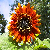

In [10]:
img

build a dataset containing the new image

test the obtained model

In [11]:
_, test_ds = colabNAS.get_data()

In [12]:
def test_tflite_model(path_to_resulting_architecture, test_ds):
    # Convert the Path object to a string
    interpreter = tf.lite.Interpreter(model_path=str(path_to_resulting_architecture))
    interpreter.allocate_tensors()

    output = interpreter.get_output_details()[0]  # Model has single output.
    input = interpreter.get_input_details()[0]  # Model has single input.
    input_dtype = input['dtype']

    correct = 0
    wrong = 0

    for images_batch, labels_batch in test_ds:
        for image, label in zip(images_batch, labels_batch):
            # Check if the input type is quantized, then rescale input data to uint8
            if input_dtype == np.uint8 or input_dtype == tf.uint8:
                input_scale, input_zero_point = input["quantization"]
                image = image / input_scale + input_zero_point
            input_data = np.expand_dims(image.numpy().astype(input_dtype), axis=0)
            interpreter.set_tensor(input['index'], input_data)
        interpreter.invoke()
        if label.numpy().argmax() == interpreter.get_tensor(output['index']).argmax() :
            correct = correct + 1
        else :
            wrong = wrong + 1
    print(f"\nTflite model test accuracy: {correct/(correct+wrong)}")

In [14]:
test_tflite_model(path_to_tflite_model, test_ds)


Tflite model test accuracy: 0.7777777777777778
